# Libraries

In [40]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [41]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_tx_analog, rf_tx_fw

reload(calc)
reload(ofdm)
reload(rf_tx_analog)
reload(rf_tx_fw)

<module 'rfdsppy.rf_tx_fw' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rf_tx_fw.py'>

# Rapp Saleh (memoryless)

In [19]:
def get_pa_params(target_comp):
    # Return PA params to target various compression points
    # PA gain = 30dB, PA output power = 27dBm
    
    pa_gain = 30 # dB
    pa_gain_lin = 10**(pa_gain/20)
    
    pa_params = {'g':pa_gain_lin}
    pa_params['smoothness'] = 2
    pa_params['a'] = 1
    pa_params['b'] = 30
    
    if target_comp == 1:
        pa_params['osat'] = 13
    elif target_comp == 2:
        pa_params['osat'] = 10
    elif target_comp == 3:
        pa_params['osat'] = 8.5
    else:
        pa_params['osat'] = target_comp
        
    return pa_params

In [20]:
modorder = 4
clipped_papr = 4.5; mpr = 1
unclipped_papr = 6.5
p_avg = 27 # dBm @ PA output (RF power) for MPR0
p_avg = p_avg-mpr
p_peak = p_avg+(clipped_papr+3) # peak power
p_avg = p_peak-(unclipped_papr+3) # average power without clipping
# v_rms = calc.dbm2v(p_avg, 'dBm')
v_rms = calc.dbm2v(p_avg+3, 'dBm') # +3 b/c this is lowpass equivalent simulation
pa_gain = 30 # dB
pa_gain_lin = 10**(pa_gain/20)
v_rms_in = v_rms/pa_gain_lin
target_comp = 3

bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 4
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr)

In [ ]:
pa_params = get_pa_params(target_comp)

pa = rf_tx_analog.RappSaleh(cfg=pa_params)

x, x_standard = ofdm_wavgen.generate(nsym=14, seed=0)
x_rf = x/calc.rms(x)*v_rms_in # scale to PA input setpoint
cfg = ofdm_wavgen.get_demod_params()

y_rf = pa.transform(x_rf)

evm = ofdm_wavgen.calculate_evm(x_standard, y_rf[round(cfg["wola_len"]/2):], en_plot=True)
print(f"EVM: {evm.round(2)}%")
cp, _ = calc.comp_db(x, y_rf, cfg={"en_plot": True})
print(f"Compression: {cp.round(2)} dB")

In [ ]:
fs = cfg.get("fs")
rbw = scs/1000/2**2

py, f = calc.psd(y_rf, fs, rbw)
px, _ = calc.psd(x_rf, fs, rbw)
py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), label="PA In")
plt.plot(f, 10*np.log10(py), label="PA Out")
plt.title("PSD", {'fontsize':40})
plt.xlabel("Frequency (MHz)", {'fontsize':30})
plt.ylabel("PSD (dBm/Bin)", {'fontsize':30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()

## DPD training

In [42]:
y_dig = y_rf/np.abs(y_rf).max()
x_dig = x/np.abs(x).max()

x_dpd, _ = rf_tx_fw.ila_dpd_training(x_dig, y_dig)

In [46]:
print(calc.rms(x_dig))
print(np.abs(x_dig).max())
print(calc.rms(x_dpd))
print(np.abs(x_dpd).max())

0.4376978841675928
0.9999999999999999
0.30941060331723325
0.9725734248097305


EVM: 0.15%
Compression: 3.15 dB


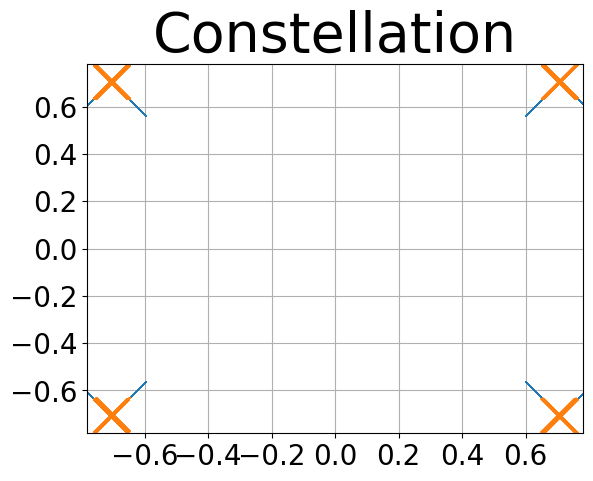

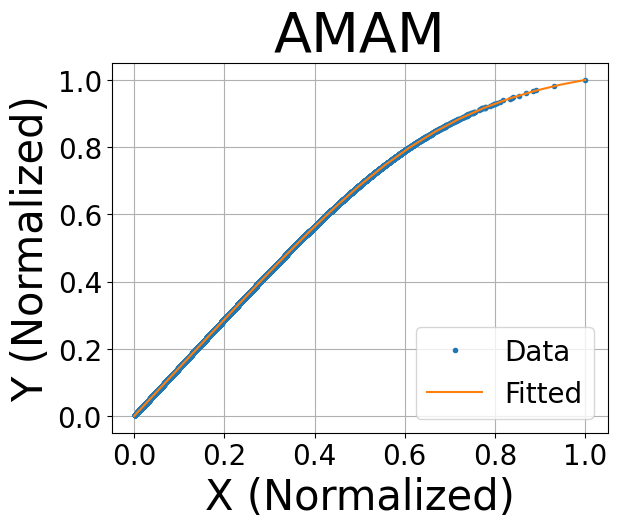

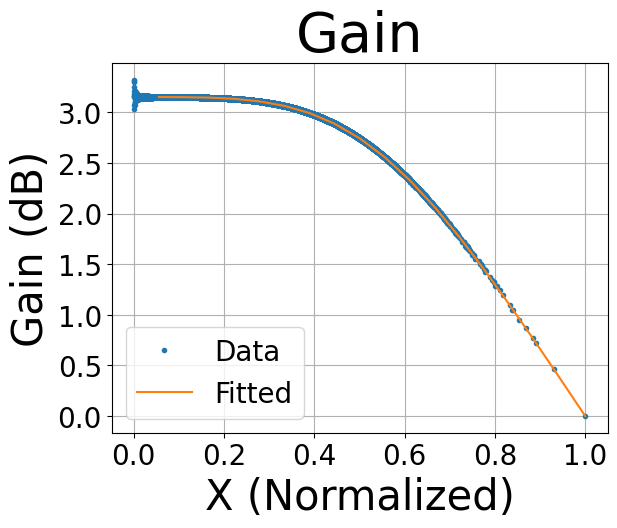

In [43]:
x_dpd_rf = x_dpd/np.abs(x_dpd).max()*np.abs(x_rf).max()
y_dpd_rf = pa.transform(x_dpd_rf)

evm = ofdm_wavgen.calculate_evm(x_standard, y_dpd_rf[round(cfg["wola_len"]/2):], en_plot=True)
print(f"EVM: {evm.round(2)}%")
cp, _ = calc.comp_db(x_dpd_rf, y_dpd_rf, cfg={"en_plot": True})
# cp, _ = calc.comp_db(x_dig, x_dpd, cfg={"en_plot": True})
print(f"Compression: {cp.round(2)} dB")

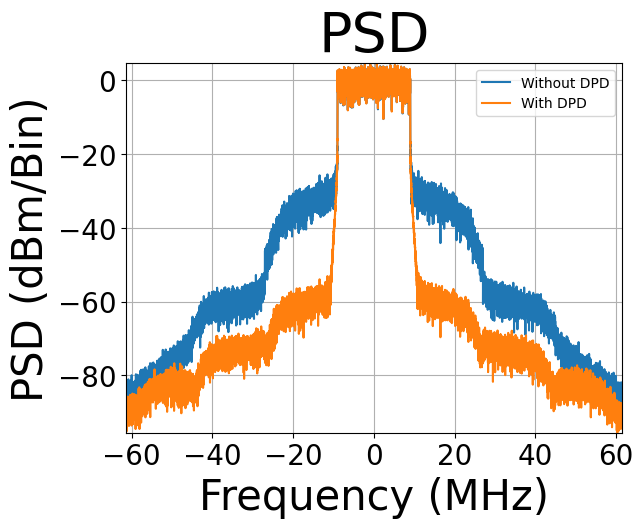

In [45]:
fs = cfg.get("fs")
rbw = scs/1000/2**2

py, f = calc.psd(y_rf, fs, rbw)
px, _ = calc.psd(y_dpd_rf, fs, rbw)
py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(py), label="Without DPD")
plt.plot(f, 10*np.log10(px), label="With DPD")
plt.title("PSD", {'fontsize':40})
plt.xlabel("Frequency (MHz)", {'fontsize':30})
plt.ylabel("PSD (dBm/Bin)", {'fontsize':30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()